<a href="https://colab.research.google.com/github/shanberochka/University_article/blob/main/Coverage_Prob_Compute.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy
import numpy as np
import scipy
import scipy.optimize
from scipy.stats import chi2
import random 
import matplotlib.pyplot as plt

In [ ]:
class Radii_Compute:
  """
  This function compute radius for w and ~w.
  It takes two parameters: tau and p.
  tau - ... is squared t, where t can take a value between 0 and 50 with step 0.5.
  p - degrees of freedom for the chi-square, that is the value 3, 5, 7 or 10.
  """
  def __init__(self):
 
    self.tbl_for_w = np.zeros([101,4])
    self.tbl_for_tilde_w = np.zeros([101,4])
    self.tbl_for_w_formula = np.zeros([101,4])
    self.tbl_for_w_formula_mail = np.zeros([101,4])
    
    self.taus = np.linspace(0, 50, 101)
    self.ps = [3, 5, 10, 15]
    self.cs = [scipy.stats.chi2.ppf(0.95, df= p) for p in self.ps]
 
  def formating_4(self, num):
    return float(format(num, ".4f"))
 
  def calc_rad_for_w(self, tau, p, c):
    def w(T, tau):
      root = ((T - tau)**2)/4 + T*tau - (p-2)*(tau-T)
      if root >= 0:
          return p-2 + (T-tau)/2 + root**0.5
      else:
          return -1
    f = lambda T: w(T,tau) - c
    return self.formating_4((scipy.optimize.bisect(f,0, 1000))**0.5)

  def calc_rad_for_w_formula(self, tau, p, c):
    T = ((c**2 - 2*c*p + c*tau + 4*c+p**2-4*p+4)/(c+tau))**0.5
    return self.formating_4(T)
  def calc_rad_for_w_formula_mail(self, tau, p, c):
    T = 2*(p - 2 - c**2 - tau**2)/(2*tau**2+p-2+c**2)
    return self.formating_4(T)

  def calc_rad_for_tilde_w(self, tau, p, c):
    a = p - 2
    if tau == 0:
      T = ((c-a)**2/c)**0.5
      return self.formating_4(T)
 
    def root1(T):
      return 0.5*(-(4*a*tau - 8*a*(tau*T)**0.5+4*a*T+tau**2+T**2-2*tau*T)**0.5 + 2*a+tau+T)
    def root2(T):
      return 0.5*((4*a*tau - 8*a*(tau*T)**0.5+4*a*T+tau**2+T**2-2*tau*T)**0.5 + 2*a+tau+T)
    def root3(T):
      return 0.5*(-(4*a*tau + 8*a*(tau*T)**0.5+4*a*T+tau**2+T**2-2*tau*T)**0.5 + 2*a+tau+T)
    def root4(T):
      return 0.5*((4*a*tau + 8*a*(tau*T)**0.5+4*a*T+tau**2+T**2-2*tau*T)**0.5 + 2*a+tau+T)
 
    def calc_root(T):
      if (tau<T):
        v1 = root2(T)
        v2 = root4(T)
      elif (tau==T):
        v1, v2 = T+a, T+a
      else:
        v1 = root1(T)
        v2 = root3(T)
      return v1, v2
 
    def h(x, T):
      return 1/(2*tau**0.5)*(a - x - tau + (a*(tau - T)/(T + a - x)))
  
    def I(v1, v2, T):
      return 1/(2*tau**0.5)*((a-tau)*(v2-v1)-0.5*(v2**2-v1**2)-a*(tau-T)*np.log((T+a-v2)/(T+a-v1)))
  
    def w_(T):
      v1, v2 = calc_root(T)
      v = v1**(3/2) + v2**(3/2)
      return ((3/4*(2/3*v+I(v1, v2, T)))**2)**(1/3)
  
    f = lambda T: w_(T) - c
    res = (scipy.optimize.bisect(f,0, 1000))**0.5
  
    return self.formating_4(res)#, formating_4(res - c**0.5)
 
  def get_tables(self):
    for t in range(101): 
      for pj in range(4):
        p = self.ps[pj]
        tau = self.taus[t]**2
        c = self.cs[pj]
        self.tbl_for_w[t, pj] = self.calc_rad_for_w(tau, p, c)
        self.tbl_for_w_formula[t, pj] = self.calc_rad_for_w_formula(tau, p, c)
        self.tbl_for_w_formula_mail[t, pj] = self.calc_rad_for_w_formula_mail(tau, p, c)
        self.tbl_for_tilde_w[t, pj] = self.calc_rad_for_tilde_w(tau, p, c)
    return self.tbl_for_w, self.tbl_for_tilde_w, self.tbl_for_w_formula, self.tbl_for_w_formula_mail

In [ ]:
radii = Radii_Compute()
tbl_for_w, tbl_for_tilde_w, tbl_for_w_formula, tbl_for_w_formula_mail = radii.get_tables()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in log
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


In [ ]:
class Calculate_Probability():
  """
  
  """
  def __init__(self, tau, p, n, N, quantile, index, radius_for_w, radius_for_tilde_w):
    self.tau = tau**2
    self.p = p
    self.a = self.p - 2
    self.c = chi2.ppf(quantile, df=self.p)
    self.sigmas = [1]*self.p
    self.n = n
    self.N = N

    self.index = index

    self.radius_for_w = radius_for_w
    self.radius_for_tilde_w = radius_for_tilde_w
 
    self.thetas = self.generate_theta()
    self.X_ = self.generate_sample()
 
    self.delta_plus = self.get_delta_plus()
 
    self.T_squared = self.get_T_squared()
 
    self.c_0 = self.tau*(4*self.a-self.tau)/(2*(2*self.tau*self.a+self.a**2)**0.5+2*self.a+self.tau)
 
    self.eps = 1e-5
 
  def generate_theta(self):
    #theta = (self.tau/(self.n*self.p))**0.5
    #thetas = [numpy.array([theta])]*self.p
    thetas = [0]*p
    thetas[self.index] = (self.tau/self.n)**0.5
    return thetas
  
  def generate_sample(self):
    X_ = []
    for i in range(self.p):
      X_.append(numpy.random.normal(self.thetas[i], self.sigmas[i]/(self.n)**0.5, self.N))
    return X_
 
  def get_delta_plus(self):
    X_ = numpy.transpose(self.X_)
    #X_ = X_ - [self.thetas]*self.N
    norma_squared = []
    for i in range(self.N):
      norma_squared.append(sum([x**2 for x in X_[i]]))
    delta = []
    for i in range(self.N):
      delta.append(numpy.multiply(X_[i], max(0, 1-(self.a)/(self.n*norma_squared[i]))))
    return delta
 
  def get_T_squared(self):
    T_squared = []
    for i in range(self.N):
      T_squared.append(self.n*sum([(theta_i - delta_i)**2 for theta_i, delta_i in zip(self.thetas, self.delta_plus[i])]))
    return T_squared
 
  def root1(self, T):
    return 0.5*(-(4*self.a*self.tau - 8*self.a*(self.tau*T)**0.5+4*self.a*T+self.tau**2+T**2-2*self.tau*T)**0.5 + 2*self.a+self.tau+T)
  def root2(self, T):
    return 0.5*((4*self.a*self.tau - 8*self.a*(self.tau*T)**0.5+4*self.a*T+self.tau**2+T**2-2*self.tau*T)**0.5 + 2*self.a+self.tau+T)
  def root3(self, T):
    return 0.5*(-(4*self.a*self.tau + 8*self.a*(self.tau*T)**0.5+4*self.a*T+self.tau**2+T**2-2*self.tau*T)**0.5 + 2*self.a+self.tau+T)
  def root4(self, T):
    return 0.5*((4*self.a*self.tau + 8*self.a*(self.tau*T)**0.5+4*self.a*T+self.tau**2+T**2-2*self.tau*T)**0.5 + 2*self.a+self.tau+T) 
 
  def calc_root(self, T):
    if (abs(self.tau-T)<=self.eps):
      v1, v2 = T+self.a, T+self.a
    elif (self.tau<T):
      v1 = self.root2(T)
      v2 = self.root4(T)
      h_v1 = self.hyperbola(v1, T)
      h_v2 = self.hyperbola(v2, T)
      if h_v1 <0:
        v1 = T+self.a
    else:
      v1 = self.root1(T)
      v2 = self.root3(T)
    return v1, v2
  
  def hyperbola(self, x, T):
    return 1/(2*self.tau**0.5)*(self.a-x-self.tau+self.a*(self.tau-T)/(T+self.a-x))
 
  def I(self, v1, v2, T):
    return 1/(2*self.tau**0.5)*((self.a-self.tau)*(v2-v1)-0.5*(v2**2-v1**2)-self.a*(self.tau-T)*numpy.log((T+self.a-v2)/(T+self.a-v1)))
 
  def w_tilde_calc(self, T):
    if self.tau == 0:
      return 0.5*((T**2+4*self.a*T)**0.5+2*self.a+T)
    v1, v2 = self.calc_root(T)
    v = v1**(3/2) + v2**(3/2)
    return ((3/4*(2/3*v+self.I(v1, v2, T)))**2)**(1/3)
  
  def get_w_tilde(self):
    w_tilde = []
    for i in range(self.N):
      w_tilde.append(self.w_tilde_calc(self.T_squared[i]))
    return w_tilde
  
  def get_w(self):
    w = []
    for i in range(self.N):
      d = self.T_squared[i]-self.tau
      w.append(self.a+d/2+(d**2/4+self.T_squared[i]*self.tau+self.a*d)**0.5)
    return w
 
  def calc_prob(self):
    include_num_for_w = 0
    include_num_for_tilde_w = 0
    #W_ = self.get_w_tilde()
    #W = self.get_w()

    for i in range(self.N):
      P2 = self.T_squared[i]<self.c_0
      if self.T_squared[i]**0.5 < self.radius_for_w or P2:
        include_num_for_w+=1
      if self.T_squared[i]**0.5 < self.radius_for_tilde_w or P2:
        include_num_for_tilde_w+=1
    return include_num_for_w/self.N, include_num_for_tilde_w/self.N

In [ ]:
p = 3
index = random.randrange(p)

In [ ]:
index

0

In [ ]:
theta_count =  101
taus = numpy.linspace ( 0 ,  50 , theta_count) 
prob_for_w_0_05_50 = [] 
prob_for_tilde_w_0_05_50 = [] 
non_include_because_w_list = []
non_include_because_tilda_w_list = []
diff_list = []
#set_for_tau = []
#set_tau_exit = []
#non_include_because_tilda_w_index_list_big = []
p =  15
n =  1
N = 1000000
alpha =  0.05 
i = 0
for  t  in  taus: 
  print(t)
  radius_for_w = tbl_for_w_formula[i][3]
  radius_for_tilde_w = tbl_for_tilde_w[i][3]
  model = Calculate_Probability (t, p, n, N, 1-alpha, index, radius_for_w, radius_for_tilde_w) 
  prob_for_w_per_tau, prob_for_tilde_w_per_tau =  model.calc_prob()
  prob_for_w_0_05_50.append(prob_for_w_per_tau)
  prob_for_tilde_w_0_05_50.append(prob_for_tilde_w_per_tau) 
  #non_include_because_w_list.append(non_include_because_w)
  #non_include_because_tilda_w_list.append(non_include_because_tilde_w)
  #diff_list.append(diff)
  i+=1
  #if t == taus[3]:
    #set_for_tau = set_tau_exit 
  #non_include_because_tilda_w_index_list_big.append(non_include_because_tilda_w_index_list)

In [ ]:
import pandas as pd
df = pd.DataFrame(prob_for_tilde_w_0_05_50, index=taus)

In [ ]:
prob_for_w_0_05_50_p_15 = prob_for_w_0_05_50
prob_for_tilde_w_0_05_50_p_15 = prob_for_tilde_w_0_05_50

In [ ]:
file = open("prob_for_tilde_w_0_05_50_p_15.txt", 'w')
file.write(str(prob_for_tilde_w_0_05_50_p_15))
file.close()

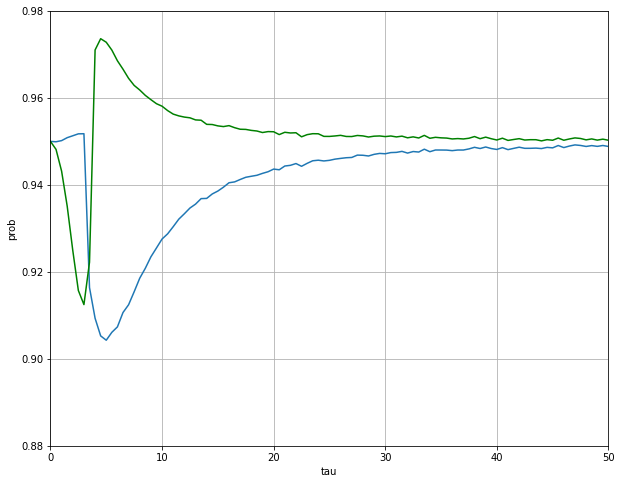

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.set(xlim=(0, 50), ylim=(0.88,0.98))
ax.set_xlabel('tau')
ax.set_ylabel('prob')
ax.grid()
 
ax.plot(taus, prob_for_w_0_05_50)
ax.plot(taus, prob_for_tilde_w_0_05_50, 'g')

In [ ]:
a = p-2
T_squared = set_for_tau[0]
H = set_for_tau[9]
R1, R2, R3, R4 = set_for_tau[1], set_for_tau[2], set_for_tau[3], set_for_tau[4]
P1, P2, P3, P4 = set_for_tau[5], set_for_tau[6], set_for_tau[7], set_for_tau[8]
fig, ax = plt.subplots(figsize=(10,7))
ax.set(xlim=(0, 30), ylim=(-3, 3))
ax.set_ylabel('y', fontsize=15)
ax.set_xlabel('x', fontsize=15)
camera = Camera(fig)
X = numpy.linspace(0, 30, 100)
y_par1 = [x**0.5 for x in X]
y_par2 = [-y for y in y_par1]
ox = [0]*len(X)
for i in range(len(T_squared)):
  ax.plot(X, y_par1, color='k', lw=2, linestyle='-')
  ax.plot(X, y_par2, color='k', lw=2, linestyle='-')
  y_h = H[i]
  #plot hyperbola
  ax.plot(X, y_h, color='r' ,lw=1, linestyle='-')
  #plot ox line
  ax.plot(X, ox, lw=1, color='k')
  #plot vertical asymptote
  ax.plot([T_squared[i]+a]*2, [-10, 10], lw=1, color='y')
  
  ax.plot(R1[i], P1[i], 'o', color = 'k')
  ax.plot(R2[i], P2[i], 'o', color = 'b')
  ax.plot(R3[i], P3[i], 'o', color = 'g')
  ax.plot(R4[i], P4[i], 'o', color = 'grey')
  print("i",i)
  camera.snap()

anim = camera.animate(interval = 1000, repeat = True, repeat_delay = 2)
HTML(anim.to_html5_video())

In [ ]:
pip install celluloid

In [ ]:
from matplotlib import animation
from IPython.display import HTML
from celluloid import Camera
%matplotlib inline